## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration

In [336]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Distortion Correction based on Camera Calibration Result

In [337]:
def undistort(img):
    img_cp = img.copy()
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    return cv2.undistort(img_cp, mtx, dist, None, mtx)

True

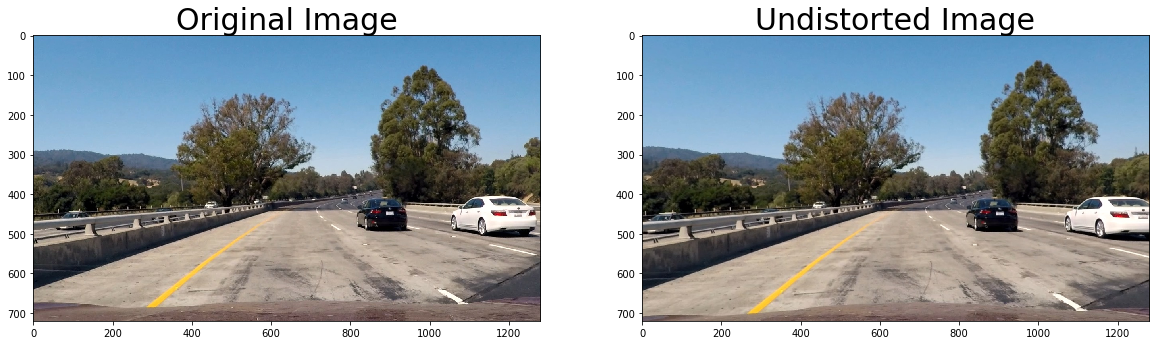

In [338]:
img = cv2.imread('test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
undistorted_img = undistort(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)
cv2.imwrite('undistorted_test1.png', undistorted_img)

# Color Tranformation

Text(0.5,1,'Binary Image')

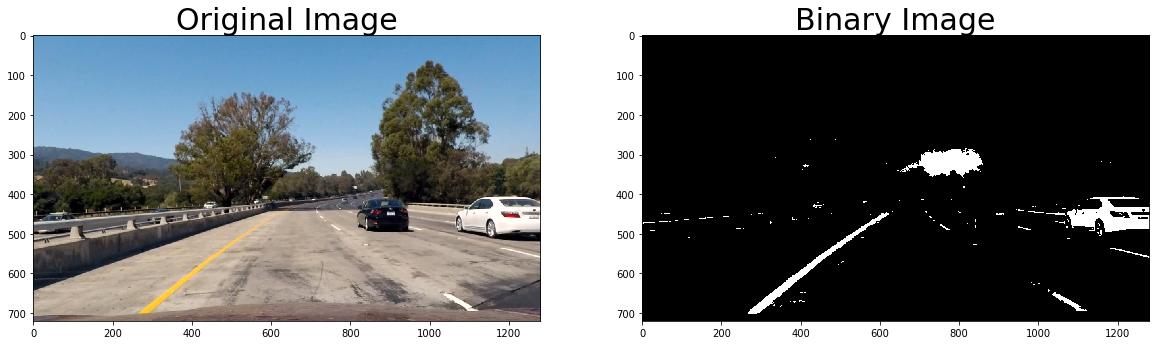

In [339]:
def abs_sobel_thresh(img, orient='x', thresh=(20, 120), sobel_kernel=15):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=15, thresh=(np.pi/4, np.pi/2 - 1)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def mag_threshold(img, sobel_kernel=15, thresh=(80, 200)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    gradmag = np.sqrt(sobelx**2, sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

def compute_hls_white_yellow_binary(rgb_img):
    hls_img = hls = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HLS)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 50))
                 & ((hls_img[:,:,1] >= 70) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 100) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

def color_transform(img, s_thresh=(170, 255)):    
    img_cp = img.copy()
    gradx = abs_sobel_thresh(img, orient='x')
    grady = abs_sobel_thresh(img, orient='y')
    mag_binary = mag_threshold(img)
    dir_binary = dir_threshold(img)
    
    combined_binary = compute_hls_white_yellow_binary(img_cp)
    # Combine the two binary thresholds
    #combined_binary = np.zeros_like(dir_binary)
    combined_binary[(gradx == 1) & ( (grady == 1) & (mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary
    
binary_img = color_transform(undistorted_img)
cv2.imwrite('binary_img.png', binary_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_img, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)


# Perspective Transformation

../test_images/test6.jpg


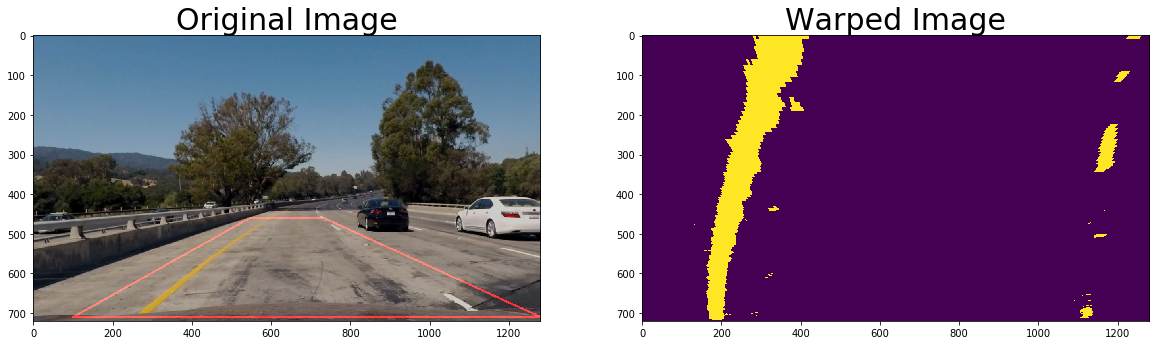

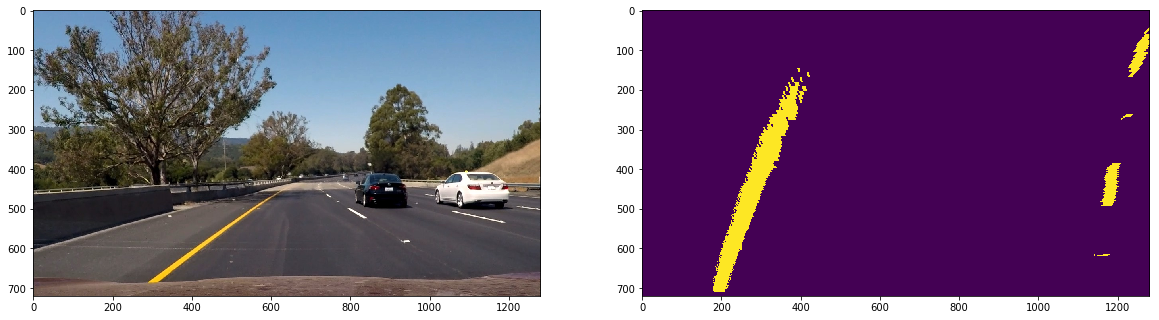

../test_images/test5.jpg


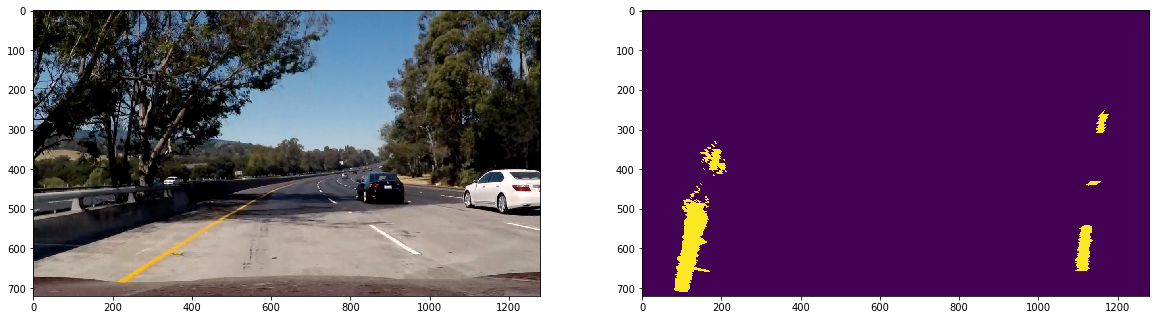

../test_images/test4.jpg


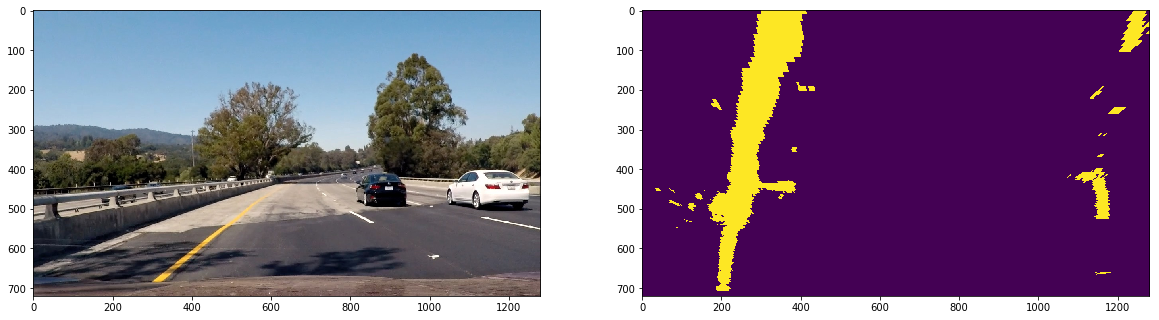

../test_images/test1.jpg


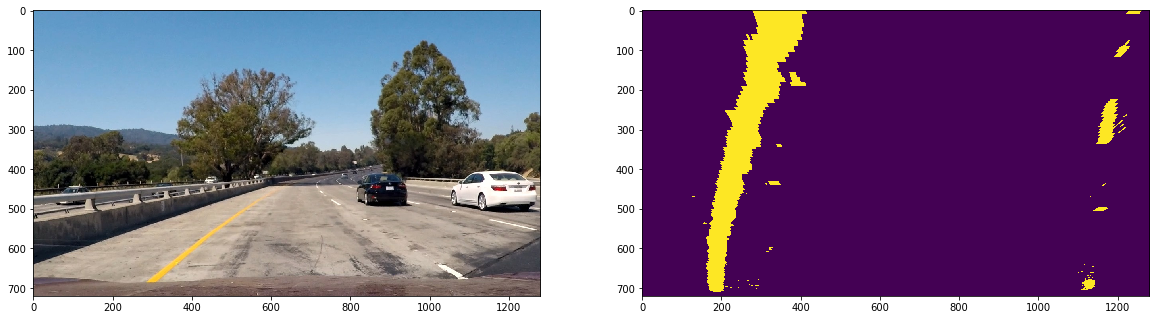

../test_images/test3.jpg


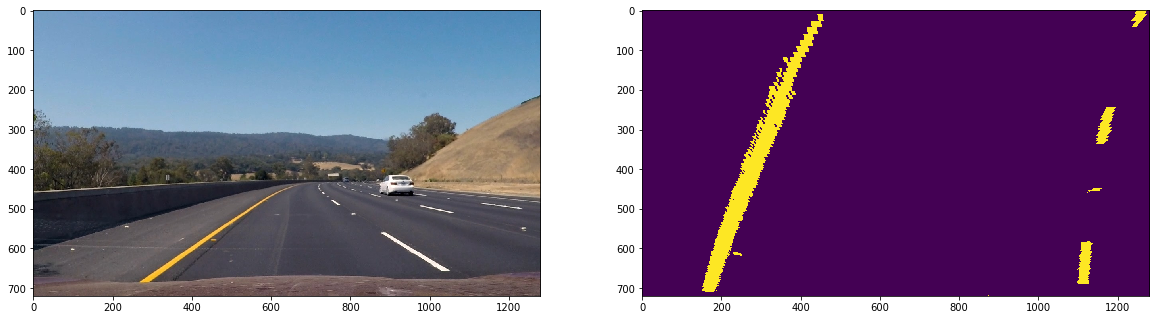

../test_images/test2.jpg


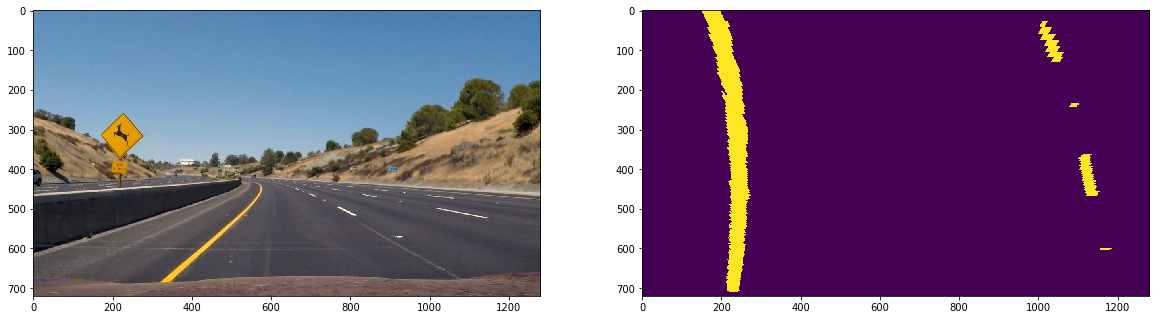

../test_images/straight_lines2.jpg


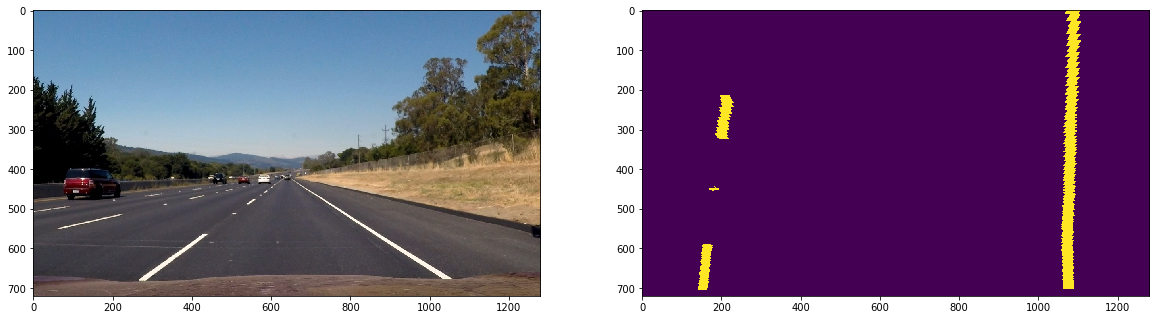

../test_images/straight_lines1.jpg


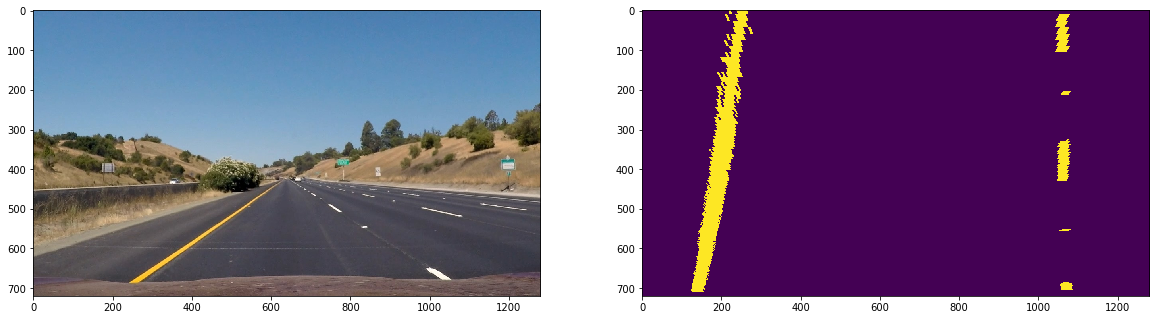

In [374]:
def warper(img, src, dst):
    img_cp = img.copy()
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img_cp, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST), M, Minv

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    img_init_cp = initial_img.copy()
    img_cp = img.copy()
    return cv2.addWeighted(img_init_cp, α, img_cp, β, γ)

def draw_lines(img, points, color=[255, 0, 0], thickness=3, dim=3):
    img_cp = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if len(points) > 2:
        cv2.line(img_cp, (points[0][0], points[0][1]), (points[len(points) - 1][0], points[len(points) - 1][1]), color, thickness)
    for i in range(1, len(points)):
        cv2.line(img_cp, (points[i - 1][0], points[i - 1][1]), (points[i][0], points[i][1]), color, thickness)
    return img_cp


# img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

# src = np.float32([
#     [img_size[0] / 2 - 40, img_size[1] / 2 + 100],
#     [img_size[0] / 6, img_size[1]],
#     [img_size[0] * 5 / 6 + 100, img_size[1]],
#     [img_size[0] / 2 + 80, img_size[1] / 2 + 100]
# ])

# dst = np.float32([
#     [img_size[0] / 4, 0],
#     [img_size[0] / 4, img_size[1]],
#     [img_size[0] * 3 / 4, img_size[1]],
#     [img_size[0] * 3 / 4, 0]
# ])

h, w = undistorted_img.shape[:2]
src = np.float32([[w, h-10], [100, h-10], [546, 460], [732, 460]])
dst = np.float32([[w-10, h], [10, h], [10,0], [w-10,0]])

warped_binary, M, Minv = warper(binary_img, src, dst)
warped_img, M, Minv = warper(undistorted_img, src, dst)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
original_img_with_area = weighted_img(draw_lines(undistorted_img, src), undistorted_img)
cv2.imwrite('original_img_with_area.png', original_img_with_area)
warped_img_with_area = weighted_img(draw_lines(warped_img, dst), warped_img)
cv2.imwrite('warped_img_with_area.png', warped_img_with_area)
ax1.imshow(original_img_with_area)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_binary)
ax2.set_title('Warped Image', fontsize=30)


# Make a list of calibration images
images = glob.glob('../test_images/*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    print(fname)
    iii = cv2.imread(fname)
    iii = cv2.cvtColor(iii, cv2.COLOR_BGR2RGB)
    warped_img, M, Minv = warper(color_transform(iii), src, dst)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(iii)
    ax2.imshow(warped_img)
    plt.show()

# Line Boundary Detection

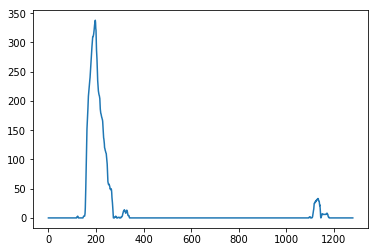

In [341]:
def hist(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

# Create histogram of image binary activations
histogram = hist(warped_binary)
cv2.imwrite('histogram.png', histogram)
# Visualize the resulting histogram
plt.plot(histogram)

## Sliding Window I

In [375]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    binary_warped_cp = binary_warped.copy()
    out_img = np.dstack((binary_warped_cp, binary_warped_cp, binary_warped_cp))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # 
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, draw=False):
    binary_warped_cp = binary_warped.copy()
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped_cp)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fit = None
    right_fit = None
    try:
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    if draw:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty


out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary, True)
cv2.imwrite('sliding_window_I.png', out_img)
plt.imshow(warped_binary)

## Sliding Window II

In [376]:
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

# window_centroids = find_window_centroids(warped_binary, window_width, window_height, margin)

# # If we found any window centers
# if len(window_centroids) > 0:

#     # Points used to draw all the left and right windows
#     l_points = np.zeros_like(warped_binary)
#     r_points = np.zeros_like(warped_binary)

#     # Go through each level and draw the windows 	
#     for level in range(0,len(window_centroids)):
#         # Window_mask is a function to draw window areas
#         l_mask = window_mask(window_width,window_height,warped_binary,window_centroids[level][0],level)
#         r_mask = window_mask(window_width,window_height,warped_binary,window_centroids[level][1],level)
#         # Add graphic points from window mask here to total pixels found 
#         l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
#         r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

#     # Draw the results
#     template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
#     zero_channel = np.zeros_like(template) # create a zero color channel
#     template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
#     warpage= np.dstack((warped_binary, warped_binary, warped_binary))*255 # making the original road pixels 3 color channels
#     output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# # If no window centers found, just display orginal road image
# else:
#     output = np.array(cv2.merge((warped_binary,warped_binary,warped_binary)),np.uint8)

# # Display the final results
# plt.imshow(output)
# plt.title('window fitting results')
# plt.show()


## Sliding Window III

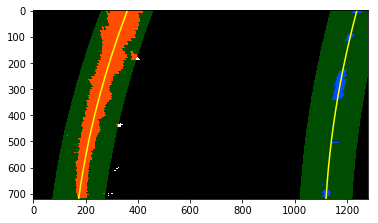

In [377]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0 or len(rightx) == 0:
        return None, None, None, None

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary, left_fit, right_fit)
cv2.imwrite('sliding_window_III.png', result)
# View your output
plt.imshow(result)

# Curvature Computation and Vehicle Relative Position

In [379]:
def measure_curvature_real(binary_warped):
    
    binary_warped_cp = binary_warped.copy()
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped_cp)

    try:
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    except Exception:
        return 0, 0, 0
    y_eval = max(np.max(lefty), np.max(righty))
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    histogram = hist(binary_warped_cp)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    offset_center = ((rightx_base + leftx_base) / 2 - 640) * xm_per_pix
    return left_curverad, right_curverad, offset_center

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad, offset_center = measure_curvature_real(warped_binary)

print(left_curverad, 'm', right_curverad, 'm', offset_center, 'm')

897.356228373 m 1136.41887989 m 0.126857142857 m


# Lane Boundary Plot

In [380]:
def mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty):
    road_warp = np.zeros_like(warped_binary).astype(np.uint8)
    color_road_warp = np.dstack((road_warp, road_warp, road_warp))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flip(np.transpose(np.vstack([right_fitx, ploty])), axis=0)])
    points = np.hstack((pts_left, pts_right))

    cv2.polylines(color_road_warp, np.int_([points]), isClosed=False, color=(0, 0, 255), thickness=40)

    cv2.fillPoly(color_road_warp, np.int_([points]), color=[0,255,0])

    transformed_color_road_warp = cv2.warpPerspective(color_road_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0]), flags=cv2.INTER_NEAREST)
    return cv2.addWeighted(undistorted_img, 1, transformed_color_road_warp, 0.3, 0)

marked_lane = mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty)
cv2.imwrite('lane_boundary.png', marked_lane)
plt.imshow(marked_lane)
plt.show()

In [381]:
def draw_info_board(img, curvature, offset):
    img_cp = img.copy()
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = [(10,80), (10, 150)]
    fontScale              = 2
    fontColor              = (0,0,0)
    lineType               = 4
    
    temp = np.zeros_like(img_cp).astype(np.uint8)
    points = np.array([[0, 0], [0, 200], [1280, 200], [1280, 0]])
    cv2.polylines(temp, np.int_([points]), isClosed=True, color=(169,169,169), thickness=40)
    cv2.fillPoly(temp, np.int_([points]), color=[169,169,169])
    result = cv2.addWeighted(img_cp, 1, temp, 0.3, 0)
    
    cv2.putText(result, "Radius of Curvature = %d(m)" % curvature, bottomLeftCornerOfText[0], font, fontScale, fontColor, lineType)
    if offset > 0:
        orientation = 'right'
    else:
        orientation = 'left'
        offset = -offset
    cv2.putText(result, "Vehicle is %.2f m %s of center" % (offset, orientation), bottomLeftCornerOfText[1], font, fontScale, fontColor, lineType)
    return result

lane_boundary_with_info = draw_info_board(marked_lane, 0, 0)
cv2.imwrite('lane_boundary_with_info.png', lane_boundary_with_info)
plt.imshow(lane_boundary_with_info)
plt.show()

# Pipeline for single frame

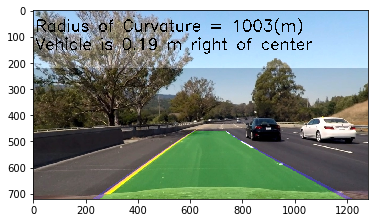

In [382]:
detected = False
prev_left_fit = None
prev_right_fit = None

def pipeline(frame):
    frame_cp = frame.copy()
    undistorted_img = undistort(frame_cp)
    
    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

    src = np.float32([
        [img_size[0] / 2 - 55, img_size[1] / 2 + 100],
        [img_size[0] / 6 + 20, img_size[1]],
        [img_size[0] * 5 / 6 + 60, img_size[1]],
        [img_size[0] / 2 + 75, img_size[1] / 2 + 100]
    ])

    dst = np.float32([
        [img_size[0] / 4, 0],
        [img_size[0] / 4, img_size[1]],
        [img_size[0] * 3 / 4, img_size[1]],
        [img_size[0] * 3 / 4, 0]
    ])

    binary_img = color_transform(undistorted_img)

    warped_binary, M, Minv = warper(binary_img, src, dst)
    
    warped_binary_cp = warped_binary.copy()
    
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary_cp)
    
#     global detected
#     global prev_left_fit
#     global prev_right_fit
#     if detected:
#         result, left_fitx, right_fitx, ploty = search_around_poly(warped_binary_cp, prev_left_fit, prev_right_fit)
#         if result is None:
#             out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary_cp)
#             prev_left_fit = left_fit
#             prev_right_fit = right_fit
#         else:
#             prev_left_fit = np.polyfit(left_fitx, ploty, 2)
#             prev_right_fit = np.polyfit(right_fitx, ploty, 2)
#     else:
#         out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(warped_binary_cp)
#         prev_left_fit = left_fit
#         prev_right_fit = right_fit
#         detected = True
    
    left_curverad, right_curverad, offset_center = measure_curvature_real(warped_binary)
    
    result = mark_lane(warped_binary, Minv, undistorted_img, left_fitx, right_fitx, ploty)
    
    return draw_info_board(result, (left_curverad + right_curverad) / 2, offset_center)

img = cv2.imread('../test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(pipeline(img))
plt.show()

# Pipeline for Streaming Videos

In [351]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'project_video_improvement_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../project_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_improvement_output.mp4.
Moviepy - Writing video project_video_improvement_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_improvement_output.mp4
CPU times: user 21min 32s, sys: 49.5 s, total: 22min 21s
Wall time: 21min 59s


In [353]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [383]:
challenge_video_output = 'challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../challenge_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(challenge_video_output, audio=False)



                                                      


                                                     
                                                               




                                                



                                                

t:   2%|▏         | 8/485 [14:42<08:08,  1.02s/it, now=None]


t:   2%|▏         | 8/485 [34:22<07:32,  1.05it/s, now=None]ne]




t:  36%|███▌      | 427/1199 [13:15<16:19,  1.27s/it, now=None]



t:   2%|▏         | 8/485 [13:25<07:55,  1.00it/s, now=None]

                                                      


                                                     
                                                               




                                                



                                                

t:   2%|▏         | 8/485 [14:42<08:08,  1.02s/it, now=None]


t:   2%|▏         | 8/485 [34:23<07:32,  1.05it/s, now=None]ne]




t:  36%|███▌      | 427/1199 [13:15<16:19,  1

Moviepy - Building video challenge_video_output.mp4.
Moviepy - Writing video challenge_video_output.mp4









t:   0%|          | 2/485 [00:01<04:12,  1.91it/s, now=None]





t:   1%|          | 3/485 [00:02<05:51,  1.37it/s, now=None]





t:   1%|          | 4/485 [00:03<06:42,  1.20it/s, now=None]





t:   1%|          | 5/485 [00:04<07:05,  1.13it/s, now=None]





t:   1%|          | 6/485 [00:05<07:28,  1.07it/s, now=None]





t:   1%|▏         | 7/485 [00:06<07:46,  1.02it/s, now=None]





t:   2%|▏         | 8/485 [00:07<07:50,  1.01it/s, now=None]





t:   2%|▏         | 9/485 [00:08<08:02,  1.01s/it, now=None]

The function failed to fit a line!








t:   2%|▏         | 10/485 [00:09<08:09,  1.03s/it, now=None]

The function failed to fit a line!








t:   2%|▏         | 11/485 [00:10<08:30,  1.08s/it, now=None]

The function failed to fit a line!








t:   2%|▏         | 12/485 [00:11<08:39,  1.10s/it, now=None]

The function failed to fit a line!








t:   3%|▎         | 13/485 [00:13<08:41,  1.11s/it, now=None]





t:   3%|▎         | 14/485 [00:14<08:28,  1.08s/it, now=None]





t:   3%|▎         | 15/485 [00:15<08:25,  1.08s/it, now=None]





t:   3%|▎         | 16/485 [00:16<08:20,  1.07s/it, now=None]





t:   4%|▎         | 17/485 [00:17<08:27,  1.08s/it, now=None]





t:   4%|▎         | 18/485 [00:18<08:19,  1.07s/it, now=None]





t:   4%|▍         | 19/485 [00:19<08:15,  1.06s/it, now=None]





t:   4%|▍         | 20/485 [00:20<08:16,  1.07s/it, now=None]





t:   4%|▍         | 21/485 [00:21<08:19,  1.08s/it, now=None]





t:   5%|▍         | 22/485 [00:22<08:16,  1.07s/it, now=None]





t:   5%|▍         | 23/485 [00:23<08:17,  1.08s/it, now=None]





t:   5%|▍         | 24/485 [00:24<08:17,  1.08s/it, now=None]





t:   5%|▌         | 25/485 [00:26<08:28,  1.11s/it, now=None]





t:   5%|▌         | 26/485 [00:27<08:25,  1.10s/it, now=None]





t:   6%|▌         | 27/485 [00:28<08:20,  1.09s/it, now=

t:  22%|██▏       | 109/485 [01:52<06:20,  1.01s/it, now=None]





t:  23%|██▎       | 110/485 [01:53<06:18,  1.01s/it, now=None]





t:  23%|██▎       | 111/485 [01:54<06:16,  1.01s/it, now=None]





t:  23%|██▎       | 112/485 [01:55<06:14,  1.00s/it, now=None]





t:  23%|██▎       | 113/485 [01:56<06:13,  1.00s/it, now=None]





t:  24%|██▎       | 114/485 [01:57<06:11,  1.00s/it, now=None]





t:  24%|██▎       | 115/485 [01:58<06:09,  1.00it/s, now=None]





t:  24%|██▍       | 116/485 [01:59<06:08,  1.00it/s, now=None]





t:  24%|██▍       | 117/485 [02:00<06:09,  1.00s/it, now=None]





t:  24%|██▍       | 118/485 [02:01<06:09,  1.01s/it, now=None]





t:  25%|██▍       | 119/485 [02:02<06:09,  1.01s/it, now=None]





t:  25%|██▍       | 120/485 [02:03<06:07,  1.01s/it, now=None]





t:  25%|██▍       | 121/485 [02:04<06:07,  1.01s/it, now=None]





t:  25%|██▌       | 122/485 [02:05<06:05,  1.01s/it, now=None]





t:  25%|██▌       | 123/485 [02:06<06:03,  1.00s

The function failed to fit a line!








t:  28%|██▊       | 136/485 [02:19<05:47,  1.00it/s, now=None]

The function failed to fit a line!








t:  28%|██▊       | 137/485 [02:20<05:50,  1.01s/it, now=None]

The function failed to fit a line!








t:  28%|██▊       | 138/485 [02:21<05:48,  1.00s/it, now=None]

The function failed to fit a line!








t:  29%|██▊       | 139/485 [02:22<05:46,  1.00s/it, now=None]

The function failed to fit a line!








t:  29%|██▉       | 140/485 [02:23<05:44,  1.00it/s, now=None]

The function failed to fit a line!








t:  29%|██▉       | 141/485 [02:24<05:44,  1.00s/it, now=None]

The function failed to fit a line!








t:  29%|██▉       | 142/485 [02:25<05:47,  1.01s/it, now=None]

The function failed to fit a line!








t:  29%|██▉       | 143/485 [02:26<05:50,  1.03s/it, now=None]

The function failed to fit a line!








t:  30%|██▉       | 144/485 [02:27<05:48,  1.02s/it, now=None]

The function failed to fit a line!








t:  30%|██▉       | 145/485 [02:28<05:46,  1.02s/it, now=None]

The function failed to fit a line!








t:  30%|███       | 146/485 [02:29<05:43,  1.01s/it, now=None]

The function failed to fit a line!








t:  30%|███       | 147/485 [02:30<05:43,  1.02s/it, now=None]





t:  31%|███       | 148/485 [02:31<05:42,  1.02s/it, now=None]





t:  31%|███       | 149/485 [02:32<05:41,  1.02s/it, now=None]





t:  31%|███       | 150/485 [02:33<05:41,  1.02s/it, now=None]





t:  31%|███       | 151/485 [02:34<05:41,  1.02s/it, now=None]





t:  31%|███▏      | 152/485 [02:35<05:40,  1.02s/it, now=None]





t:  32%|███▏      | 153/485 [02:36<05:39,  1.02s/it, now=None]





t:  32%|███▏      | 154/485 [02:37<05:36,  1.02s/it, now=None]





t:  32%|███▏      | 155/485 [02:38<05:34,  1.01s/it, now=None]





t:  32%|███▏      | 156/485 [02:39<05:32,  1.01s/it, now=None]





t:  32%|███▏      | 157/485 [02:40<05:33,  1.02s/it, now=None]





t:  33%|███▎      | 158/485 [02:41<05:31,  1.01s/it, now=None]





t:  33%|███▎      | 159/485 [02:42<05:29,  1.01s/it, now=None]





t:  33%|███▎      | 160/485 [02:43<05:27,  1.01s/it, now=None]





t:  33%|███▎      | 161/485 [02:44<05:28, 

t:  50%|████▉     | 242/485 [04:06<04:05,  1.01s/it, now=None]





t:  50%|█████     | 243/485 [04:07<04:03,  1.01s/it, now=None]





t:  50%|█████     | 244/485 [04:08<04:02,  1.00s/it, now=None]





t:  51%|█████     | 245/485 [04:09<04:00,  1.00s/it, now=None]





t:  51%|█████     | 246/485 [04:10<04:01,  1.01s/it, now=None]





t:  51%|█████     | 247/485 [04:11<03:59,  1.01s/it, now=None]





t:  51%|█████     | 248/485 [04:12<03:57,  1.00s/it, now=None]





t:  51%|█████▏    | 249/485 [04:13<03:56,  1.00s/it, now=None]





t:  52%|█████▏    | 250/485 [04:14<03:56,  1.01s/it, now=None]





t:  52%|█████▏    | 251/485 [04:15<03:55,  1.01s/it, now=None]





t:  52%|█████▏    | 252/485 [04:16<03:54,  1.01s/it, now=None]





t:  52%|█████▏    | 253/485 [04:17<03:53,  1.01s/it, now=None]





t:  52%|█████▏    | 254/485 [04:18<03:53,  1.01s/it, now=None]





t:  53%|█████▎    | 255/485 [04:19<03:52,  1.01s/it, now=None]





t:  53%|█████▎    | 256/485 [04:20<03:51,  1.01s

t:  69%|██████▉   | 337/485 [05:43<02:42,  1.10s/it, now=None]





t:  70%|██████▉   | 338/485 [05:44<02:42,  1.11s/it, now=None]





t:  70%|██████▉   | 339/485 [05:45<02:38,  1.08s/it, now=None]





t:  70%|███████   | 340/485 [05:46<02:37,  1.09s/it, now=None]





t:  70%|███████   | 341/485 [05:47<02:48,  1.17s/it, now=None]





t:  71%|███████   | 342/485 [05:49<02:52,  1.20s/it, now=None]





t:  71%|███████   | 343/485 [05:50<02:52,  1.21s/it, now=None]





t:  71%|███████   | 344/485 [05:51<02:43,  1.16s/it, now=None]





t:  71%|███████   | 345/485 [05:52<02:37,  1.12s/it, now=None]





t:  71%|███████▏  | 346/485 [05:53<02:35,  1.12s/it, now=None]





t:  72%|███████▏  | 347/485 [05:54<02:32,  1.10s/it, now=None]





t:  72%|███████▏  | 348/485 [05:55<02:38,  1.16s/it, now=None]





t:  72%|███████▏  | 349/485 [05:57<02:38,  1.16s/it, now=None]





t:  72%|███████▏  | 350/485 [05:58<02:37,  1.17s/it, now=None]





t:  72%|███████▏  | 351/485 [05:59<02:33,  1.14s

t:  89%|████████▉ | 432/485 [07:22<00:53,  1.01s/it, now=None]





t:  89%|████████▉ | 433/485 [07:23<00:52,  1.00s/it, now=None]





t:  89%|████████▉ | 434/485 [07:24<00:51,  1.00s/it, now=None]





t:  90%|████████▉ | 435/485 [07:25<00:50,  1.00s/it, now=None]





t:  90%|████████▉ | 436/485 [07:26<00:49,  1.00s/it, now=None]





t:  90%|█████████ | 437/485 [07:27<00:48,  1.00s/it, now=None]





t:  90%|█████████ | 438/485 [07:28<00:47,  1.00s/it, now=None]





t:  91%|█████████ | 439/485 [07:29<00:46,  1.00s/it, now=None]





t:  91%|█████████ | 440/485 [07:30<00:45,  1.00s/it, now=None]





t:  91%|█████████ | 441/485 [07:31<00:44,  1.00s/it, now=None]





t:  91%|█████████ | 442/485 [07:32<00:43,  1.00s/it, now=None]





t:  91%|█████████▏| 443/485 [07:33<00:42,  1.00s/it, now=None]





t:  92%|█████████▏| 444/485 [07:34<00:40,  1.00it/s, now=None]





t:  92%|█████████▏| 445/485 [07:35<00:39,  1.00it/s, now=None]





t:  92%|█████████▏| 446/485 [07:36<00:39,  1.00s

Moviepy - Done !
Moviepy - video ready challenge_video_output.mp4
CPU times: user 8min 10s, sys: 16.6 s, total: 8min 26s
Wall time: 8min 17s


In [385]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))

In [384]:
harder_challenge_video_output = 'harder_challenge_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('../harder_challenge_video.mp4')
clips = clip2.fl_image(pipeline)
%time clips.write_videofile(harder_challenge_video_output, audio=False)



                                                      


                                                     
                                                               




                                                



                                                

t:   2%|▏         | 8/485 [23:02<08:08,  1.02s/it, now=None]


t:   2%|▏         | 8/485 [42:42<07:32,  1.05it/s, now=None]ne]




t:  36%|███▌      | 427/1199 [21:34<16:19,  1.27s/it, now=None]



t:   2%|▏         | 8/485 [21:44<07:55,  1.00it/s, now=None]

                                                      


                                                     
                                                               




                                                



                                                

t:   2%|▏         | 8/485 [23:02<08:08,  1.02s/it, now=None]


t:   2%|▏         | 8/485 [42:42<07:32,  1.05it/s, now=None]ne]




t:  36%|███▌      | 427/1199 [21:34<16:19,  1

Moviepy - Building video harder_challenge_video_output.mp4.
Moviepy - Writing video harder_challenge_video_output.mp4









t:   0%|          | 2/1199 [00:01<11:06,  1.80it/s, now=None]





t:   0%|          | 3/1199 [00:02<13:58,  1.43it/s, now=None]





t:   0%|          | 4/1199 [00:03<16:08,  1.23it/s, now=None]





t:   0%|          | 5/1199 [00:04<17:33,  1.13it/s, now=None]





t:   1%|          | 6/1199 [00:05<18:24,  1.08it/s, now=None]





t:   1%|          | 7/1199 [00:06<19:03,  1.04it/s, now=None]





t:   1%|          | 8/1199 [00:07<19:26,  1.02it/s, now=None]





t:   1%|          | 9/1199 [00:08<19:55,  1.00s/it, now=None]





t:   1%|          | 10/1199 [00:09<20:14,  1.02s/it, now=None]





t:   1%|          | 11/1199 [00:10<20:18,  1.03s/it, now=None]





t:   1%|          | 12/1199 [00:11<20:18,  1.03s/it, now=None]





t:   1%|          | 13/1199 [00:12<20:19,  1.03s/it, now=None]





t:   1%|          | 14/1199 [00:13<20:22,  1.03s/it, now=None]





t:   1%|▏         | 15/1199 [00:14<20:20,  1.03s/it, now=None]





t:   1%|▏         | 16/1199 [00:15<20:24,  1.04s/i

t:   8%|▊         | 97/1199 [01:43<19:12,  1.05s/it, now=None]





t:   8%|▊         | 98/1199 [01:44<19:08,  1.04s/it, now=None]





t:   8%|▊         | 99/1199 [01:45<19:02,  1.04s/it, now=None]





t:   8%|▊         | 100/1199 [01:46<19:01,  1.04s/it, now=None]





t:   8%|▊         | 101/1199 [01:47<19:01,  1.04s/it, now=None]





t:   9%|▊         | 102/1199 [01:48<18:56,  1.04s/it, now=None]





t:   9%|▊         | 103/1199 [01:49<18:53,  1.03s/it, now=None]





t:   9%|▊         | 104/1199 [01:50<18:50,  1.03s/it, now=None]





t:   9%|▉         | 105/1199 [01:51<19:08,  1.05s/it, now=None]





t:   9%|▉         | 106/1199 [01:52<19:00,  1.04s/it, now=None]





t:   9%|▉         | 107/1199 [01:53<18:51,  1.04s/it, now=None]





t:   9%|▉         | 108/1199 [01:54<18:45,  1.03s/it, now=None]





t:   9%|▉         | 109/1199 [01:55<18:50,  1.04s/it, now=None]





t:   9%|▉         | 110/1199 [01:56<18:46,  1.03s/it, now=None]





t:   9%|▉         | 111/1199 [01:57<1

t:  16%|█▌        | 191/1199 [03:20<17:06,  1.02s/it, now=None]





t:  16%|█▌        | 192/1199 [03:21<17:06,  1.02s/it, now=None]





t:  16%|█▌        | 193/1199 [03:22<17:04,  1.02s/it, now=None]





t:  16%|█▌        | 194/1199 [03:23<16:59,  1.01s/it, now=None]





t:  16%|█▋        | 195/1199 [03:24<16:55,  1.01s/it, now=None]





t:  16%|█▋        | 196/1199 [03:25<16:51,  1.01s/it, now=None]





t:  16%|█▋        | 197/1199 [03:26<16:56,  1.01s/it, now=None]





t:  17%|█▋        | 198/1199 [03:27<16:54,  1.01s/it, now=None]





t:  17%|█▋        | 199/1199 [03:28<16:49,  1.01s/it, now=None]





t:  17%|█▋        | 200/1199 [03:29<16:48,  1.01s/it, now=None]





t:  17%|█▋        | 201/1199 [03:30<16:53,  1.02s/it, now=None]





t:  17%|█▋        | 202/1199 [03:31<17:05,  1.03s/it, now=None]





t:  17%|█▋        | 203/1199 [03:32<17:05,  1.03s/it, now=None]





t:  17%|█▋        | 204/1199 [03:33<17:12,  1.04s/it, now=None]





t:  17%|█▋        | 205/1199 [03:3

t:  24%|██▍       | 285/1199 [04:59<15:39,  1.03s/it, now=None]





t:  24%|██▍       | 286/1199 [05:00<15:42,  1.03s/it, now=None]





t:  24%|██▍       | 287/1199 [05:01<15:37,  1.03s/it, now=None]





t:  24%|██▍       | 288/1199 [05:02<15:31,  1.02s/it, now=None]





t:  24%|██▍       | 289/1199 [05:03<15:40,  1.03s/it, now=None]





t:  24%|██▍       | 290/1199 [05:04<15:40,  1.03s/it, now=None]





t:  24%|██▍       | 291/1199 [05:05<15:36,  1.03s/it, now=None]





t:  24%|██▍       | 292/1199 [05:06<15:33,  1.03s/it, now=None]





t:  24%|██▍       | 293/1199 [05:07<15:36,  1.03s/it, now=None]





t:  25%|██▍       | 294/1199 [05:08<15:35,  1.03s/it, now=None]





t:  25%|██▍       | 295/1199 [05:09<15:31,  1.03s/it, now=None]





t:  25%|██▍       | 296/1199 [05:10<15:26,  1.03s/it, now=None]





t:  25%|██▍       | 297/1199 [05:11<15:26,  1.03s/it, now=None]





t:  25%|██▍       | 298/1199 [05:12<15:23,  1.03s/it, now=None]





t:  25%|██▍       | 299/1199 [05:1

t:  32%|███▏      | 379/1199 [06:39<16:57,  1.24s/it, now=None]





t:  32%|███▏      | 380/1199 [06:41<17:26,  1.28s/it, now=None]





t:  32%|███▏      | 381/1199 [06:42<17:41,  1.30s/it, now=None]





t:  32%|███▏      | 382/1199 [06:43<17:14,  1.27s/it, now=None]





t:  32%|███▏      | 383/1199 [06:44<17:10,  1.26s/it, now=None]





t:  32%|███▏      | 384/1199 [06:46<17:15,  1.27s/it, now=None]





t:  32%|███▏      | 385/1199 [06:47<17:09,  1.26s/it, now=None]





t:  32%|███▏      | 386/1199 [06:48<17:32,  1.29s/it, now=None]





t:  32%|███▏      | 387/1199 [06:50<17:22,  1.28s/it, now=None]





t:  32%|███▏      | 388/1199 [06:51<17:14,  1.28s/it, now=None]





t:  32%|███▏      | 389/1199 [06:52<16:52,  1.25s/it, now=None]





t:  33%|███▎      | 390/1199 [06:53<16:35,  1.23s/it, now=None]





t:  33%|███▎      | 391/1199 [06:54<16:23,  1.22s/it, now=None]





t:  33%|███▎      | 392/1199 [06:56<16:15,  1.21s/it, now=None]





t:  33%|███▎      | 393/1199 [06:5

t:  39%|███▉      | 473/1199 [08:26<12:52,  1.06s/it, now=None]





t:  40%|███▉      | 474/1199 [08:27<12:50,  1.06s/it, now=None]





t:  40%|███▉      | 475/1199 [08:28<12:48,  1.06s/it, now=None]





t:  40%|███▉      | 476/1199 [08:29<12:41,  1.05s/it, now=None]





t:  40%|███▉      | 477/1199 [08:30<12:34,  1.05s/it, now=None]





t:  40%|███▉      | 478/1199 [08:31<12:39,  1.05s/it, now=None]





t:  40%|███▉      | 479/1199 [08:32<12:37,  1.05s/it, now=None]





t:  40%|████      | 480/1199 [08:33<12:30,  1.04s/it, now=None]





t:  40%|████      | 481/1199 [08:34<12:26,  1.04s/it, now=None]





t:  40%|████      | 482/1199 [08:35<12:26,  1.04s/it, now=None]





t:  40%|████      | 483/1199 [08:36<12:27,  1.04s/it, now=None]





t:  40%|████      | 484/1199 [08:37<12:25,  1.04s/it, now=None]





t:  40%|████      | 485/1199 [08:38<12:22,  1.04s/it, now=None]





t:  41%|████      | 486/1199 [08:39<12:22,  1.04s/it, now=None]





t:  41%|████      | 487/1199 [08:4

t:  47%|████▋     | 567/1199 [10:03<10:46,  1.02s/it, now=None]





t:  47%|████▋     | 568/1199 [10:04<10:42,  1.02s/it, now=None]





t:  47%|████▋     | 569/1199 [10:05<10:39,  1.02s/it, now=None]





t:  48%|████▊     | 570/1199 [10:06<10:37,  1.01s/it, now=None]





t:  48%|████▊     | 571/1199 [10:07<10:38,  1.02s/it, now=None]





t:  48%|████▊     | 572/1199 [10:08<10:34,  1.01s/it, now=None]





t:  48%|████▊     | 573/1199 [10:09<10:30,  1.01s/it, now=None]





t:  48%|████▊     | 574/1199 [10:10<10:28,  1.01s/it, now=None]





t:  48%|████▊     | 575/1199 [10:11<10:28,  1.01s/it, now=None]





t:  48%|████▊     | 576/1199 [10:12<10:26,  1.01s/it, now=None]





t:  48%|████▊     | 577/1199 [10:13<10:24,  1.00s/it, now=None]





t:  48%|████▊     | 578/1199 [10:14<10:23,  1.00s/it, now=None]





t:  48%|████▊     | 579/1199 [10:15<10:29,  1.02s/it, now=None]





t:  48%|████▊     | 580/1199 [10:16<10:26,  1.01s/it, now=None]





t:  48%|████▊     | 581/1199 [10:1

The function failed to fit a line!








t:  49%|████▉     | 593/1199 [10:29<10:16,  1.02s/it, now=None]

The function failed to fit a line!








t:  50%|████▉     | 594/1199 [10:30<10:19,  1.02s/it, now=None]





t:  50%|████▉     | 595/1199 [10:31<10:17,  1.02s/it, now=None]





t:  50%|████▉     | 596/1199 [10:32<10:11,  1.01s/it, now=None]





t:  50%|████▉     | 597/1199 [10:33<10:09,  1.01s/it, now=None]





t:  50%|████▉     | 598/1199 [10:34<10:06,  1.01s/it, now=None]





t:  50%|████▉     | 599/1199 [10:36<10:07,  1.01s/it, now=None]





t:  50%|█████     | 600/1199 [10:37<10:05,  1.01s/it, now=None]





t:  50%|█████     | 601/1199 [10:38<10:02,  1.01s/it, now=None]





t:  50%|█████     | 602/1199 [10:39<10:00,  1.01s/it, now=None]

The function failed to fit a line!








t:  50%|█████     | 603/1199 [10:40<10:01,  1.01s/it, now=None]

The function failed to fit a line!








t:  50%|█████     | 604/1199 [10:41<09:59,  1.01s/it, now=None]

The function failed to fit a line!








t:  50%|█████     | 605/1199 [10:42<09:57,  1.01s/it, now=None]

The function failed to fit a line!








t:  51%|█████     | 606/1199 [10:43<09:59,  1.01s/it, now=None]





t:  51%|█████     | 607/1199 [10:44<10:00,  1.01s/it, now=None]





t:  51%|█████     | 608/1199 [10:45<09:56,  1.01s/it, now=None]

The function failed to fit a line!








t:  51%|█████     | 609/1199 [10:46<09:53,  1.01s/it, now=None]

The function failed to fit a line!








t:  51%|█████     | 610/1199 [10:47<09:54,  1.01s/it, now=None]

The function failed to fit a line!








t:  51%|█████     | 611/1199 [10:48<09:57,  1.02s/it, now=None]





t:  51%|█████     | 612/1199 [10:49<09:59,  1.02s/it, now=None]





t:  51%|█████     | 613/1199 [10:50<10:01,  1.03s/it, now=None]





t:  51%|█████     | 614/1199 [10:51<10:10,  1.04s/it, now=None]





t:  51%|█████▏    | 615/1199 [10:52<10:10,  1.04s/it, now=None]





t:  51%|█████▏    | 616/1199 [10:53<10:10,  1.05s/it, now=None]





t:  51%|█████▏    | 617/1199 [10:54<10:06,  1.04s/it, now=None]





t:  52%|█████▏    | 618/1199 [10:55<10:05,  1.04s/it, now=None]





t:  52%|█████▏    | 619/1199 [10:56<10:06,  1.05s/it, now=None]





t:  52%|█████▏    | 620/1199 [10:57<10:05,  1.05s/it, now=None]





t:  52%|█████▏    | 621/1199 [10:58<10:04,  1.05s/it, now=None]





t:  52%|█████▏    | 622/1199 [10:59<10:04,  1.05s/it, now=None]





t:  52%|█████▏    | 623/1199 [11:00<10:09,  1.06s/it, now=None]





t:  52%|█████▏    | 624/1199 [11:01<10:09,  1.06s/it, now=None]





t:  52%|█████▏    | 625/1199

t:  59%|█████▉    | 705/1199 [12:34<09:46,  1.19s/it, now=None]





t:  59%|█████▉    | 706/1199 [12:35<09:40,  1.18s/it, now=None]





t:  59%|█████▉    | 707/1199 [12:36<09:40,  1.18s/it, now=None]





t:  59%|█████▉    | 708/1199 [12:37<09:37,  1.18s/it, now=None]





t:  59%|█████▉    | 709/1199 [12:38<09:45,  1.20s/it, now=None]





t:  59%|█████▉    | 710/1199 [12:40<09:42,  1.19s/it, now=None]





t:  59%|█████▉    | 711/1199 [12:41<09:42,  1.19s/it, now=None]





t:  59%|█████▉    | 712/1199 [12:42<09:22,  1.15s/it, now=None]





t:  59%|█████▉    | 713/1199 [12:43<09:04,  1.12s/it, now=None]





t:  60%|█████▉    | 714/1199 [12:44<08:49,  1.09s/it, now=None]





t:  60%|█████▉    | 715/1199 [12:45<08:44,  1.08s/it, now=None]





t:  60%|█████▉    | 716/1199 [12:46<08:40,  1.08s/it, now=None]





t:  60%|█████▉    | 717/1199 [12:47<08:31,  1.06s/it, now=None]





t:  60%|█████▉    | 718/1199 [12:48<08:26,  1.05s/it, now=None]





t:  60%|█████▉    | 719/1199 [12:4

t:  67%|██████▋   | 799/1199 [14:14<07:07,  1.07s/it, now=None]





t:  67%|██████▋   | 800/1199 [14:15<07:06,  1.07s/it, now=None]





t:  67%|██████▋   | 801/1199 [14:16<07:08,  1.08s/it, now=None]





t:  67%|██████▋   | 802/1199 [14:17<07:06,  1.07s/it, now=None]





t:  67%|██████▋   | 803/1199 [14:18<07:05,  1.07s/it, now=None]





t:  67%|██████▋   | 804/1199 [14:19<07:02,  1.07s/it, now=None]





t:  67%|██████▋   | 805/1199 [14:20<07:00,  1.07s/it, now=None]





t:  67%|██████▋   | 806/1199 [14:21<06:59,  1.07s/it, now=None]





t:  67%|██████▋   | 807/1199 [14:22<06:57,  1.07s/it, now=None]





t:  67%|██████▋   | 808/1199 [14:23<06:54,  1.06s/it, now=None]





t:  67%|██████▋   | 809/1199 [14:24<06:53,  1.06s/it, now=None]





t:  68%|██████▊   | 810/1199 [14:25<06:55,  1.07s/it, now=None]





t:  68%|██████▊   | 811/1199 [14:27<07:03,  1.09s/it, now=None]





t:  68%|██████▊   | 812/1199 [14:28<06:58,  1.08s/it, now=None]





t:  68%|██████▊   | 813/1199 [14:2

t:  74%|███████▍  | 893/1199 [15:59<05:41,  1.12s/it, now=None]





t:  75%|███████▍  | 894/1199 [16:00<05:41,  1.12s/it, now=None]





t:  75%|███████▍  | 895/1199 [16:01<05:37,  1.11s/it, now=None]





t:  75%|███████▍  | 896/1199 [16:02<05:33,  1.10s/it, now=None]





t:  75%|███████▍  | 897/1199 [16:03<05:30,  1.09s/it, now=None]





t:  75%|███████▍  | 898/1199 [16:05<05:27,  1.09s/it, now=None]





t:  75%|███████▍  | 899/1199 [16:06<05:25,  1.09s/it, now=None]





t:  75%|███████▌  | 900/1199 [16:07<05:22,  1.08s/it, now=None]





t:  75%|███████▌  | 901/1199 [16:08<05:19,  1.07s/it, now=None]





t:  75%|███████▌  | 902/1199 [16:09<05:17,  1.07s/it, now=None]





t:  75%|███████▌  | 903/1199 [16:10<05:14,  1.06s/it, now=None]





t:  75%|███████▌  | 904/1199 [16:11<05:12,  1.06s/it, now=None]





t:  75%|███████▌  | 905/1199 [16:12<05:08,  1.05s/it, now=None]





t:  76%|███████▌  | 906/1199 [16:13<05:06,  1.05s/it, now=None]





t:  76%|███████▌  | 907/1199 [16:1

The function failed to fit a line!








t:  77%|███████▋  | 924/1199 [16:32<04:41,  1.02s/it, now=None]

The function failed to fit a line!








t:  77%|███████▋  | 925/1199 [16:33<04:38,  1.02s/it, now=None]

The function failed to fit a line!








t:  77%|███████▋  | 926/1199 [16:34<04:36,  1.01s/it, now=None]

The function failed to fit a line!








t:  77%|███████▋  | 927/1199 [16:35<04:34,  1.01s/it, now=None]

The function failed to fit a line!








t:  77%|███████▋  | 928/1199 [16:36<04:32,  1.01s/it, now=None]

The function failed to fit a line!








t:  77%|███████▋  | 929/1199 [16:37<04:35,  1.02s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 930/1199 [16:38<04:34,  1.02s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 931/1199 [16:39<04:31,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 932/1199 [16:40<04:29,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 933/1199 [16:41<04:28,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 934/1199 [16:42<04:27,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 935/1199 [16:43<04:27,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 936/1199 [16:44<04:26,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 937/1199 [16:45<04:25,  1.01s/it, now=None]





t:  78%|███████▊  | 938/1199 [16:46<04:24,  1.01s/it, now=None]





t:  78%|███████▊  | 939/1199 [16:47<04:22,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 940/1199 [16:48<04:20,  1.01s/it, now=None]

The function failed to fit a line!








t:  78%|███████▊  | 941/1199 [16:49<04:20,  1.01s/it, now=None]





t:  79%|███████▊  | 942/1199 [16:50<04:18,  1.01s/it, now=None]





t:  79%|███████▊  | 943/1199 [16:51<04:18,  1.01s/it, now=None]





t:  79%|███████▊  | 944/1199 [16:52<04:17,  1.01s/it, now=None]





t:  79%|███████▉  | 945/1199 [16:53<04:16,  1.01s/it, now=None]





t:  79%|███████▉  | 946/1199 [16:54<04:14,  1.01s/it, now=None]





t:  79%|███████▉  | 947/1199 [16:55<04:14,  1.01s/it, now=None]





t:  79%|███████▉  | 948/1199 [16:56<04:13,  1.01s/it, now=None]





t:  79%|███████▉  | 949/1199 [16:57<04:13,  1.01s/it, now=None]





t:  79%|███████▉  | 950/1199 [16:58<04:11,  1.01s/it, now=None]





t:  79%|███████▉  | 951/1199 [16:59<04:10,  1.01s/it, now=None]





t:  79%|███████▉  | 952/1199 [17:00<04:08,  1.01s/it, now=None]





t:  79%|███████▉  | 953/1199 [17:01<04:10,  1.02s/it, now=None]





t:  80%|███████▉  | 954/1199 [17:02<04:08,  1.02s/it, now=None]





t:  80%|███████▉  | 955/1199

The function failed to fit a line!








t:  84%|████████▍ | 1009/1199 [17:58<03:13,  1.02s/it, now=None]





t:  84%|████████▍ | 1010/1199 [17:59<03:12,  1.02s/it, now=None]





t:  84%|████████▍ | 1011/1199 [18:00<03:11,  1.02s/it, now=None]





t:  84%|████████▍ | 1012/1199 [18:01<03:10,  1.02s/it, now=None]





t:  84%|████████▍ | 1013/1199 [18:02<03:08,  1.01s/it, now=None]





t:  85%|████████▍ | 1014/1199 [18:03<03:07,  1.01s/it, now=None]





t:  85%|████████▍ | 1015/1199 [18:04<03:05,  1.01s/it, now=None]





t:  85%|████████▍ | 1016/1199 [18:05<03:04,  1.01s/it, now=None]





t:  85%|████████▍ | 1017/1199 [18:06<03:03,  1.01s/it, now=None]





t:  85%|████████▍ | 1018/1199 [18:07<03:02,  1.01s/it, now=None]





t:  85%|████████▍ | 1019/1199 [18:08<03:01,  1.01s/it, now=None]





t:  85%|████████▌ | 1020/1199 [18:09<03:00,  1.01s/it, now=None]





t:  85%|████████▌ | 1021/1199 [18:10<02:59,  1.01s/it, now=None]





t:  85%|████████▌ | 1022/1199 [18:11<03:00,  1.02s/it, now=None]





t:  85%|██████

t:  92%|█████████▏| 1102/1199 [19:38<01:47,  1.11s/it, now=None]





t:  92%|█████████▏| 1103/1199 [19:39<01:46,  1.10s/it, now=None]





t:  92%|█████████▏| 1104/1199 [19:40<01:44,  1.10s/it, now=None]





t:  92%|█████████▏| 1105/1199 [19:41<01:42,  1.09s/it, now=None]





t:  92%|█████████▏| 1106/1199 [19:42<01:40,  1.09s/it, now=None]





t:  92%|█████████▏| 1107/1199 [19:43<01:40,  1.09s/it, now=None]





t:  92%|█████████▏| 1108/1199 [19:44<01:38,  1.08s/it, now=None]





t:  92%|█████████▏| 1109/1199 [19:45<01:36,  1.07s/it, now=None]





t:  93%|█████████▎| 1110/1199 [19:46<01:35,  1.07s/it, now=None]





t:  93%|█████████▎| 1111/1199 [19:47<01:33,  1.07s/it, now=None]





t:  93%|█████████▎| 1112/1199 [19:49<01:32,  1.06s/it, now=None]





t:  93%|█████████▎| 1113/1199 [19:50<01:31,  1.06s/it, now=None]





t:  93%|█████████▎| 1114/1199 [19:51<01:30,  1.06s/it, now=None]





t:  93%|█████████▎| 1115/1199 [19:52<01:29,  1.07s/it, now=None]





t:  93%|█████████▎| 

t: 100%|█████████▉| 1195/1199 [21:16<00:04,  1.05s/it, now=None]





t: 100%|█████████▉| 1196/1199 [21:17<00:03,  1.04s/it, now=None]





t: 100%|█████████▉| 1197/1199 [21:18<00:02,  1.04s/it, now=None]





t: 100%|█████████▉| 1198/1199 [21:19<00:01,  1.04s/it, now=None]





t: 100%|██████████| 1199/1199 [21:20<00:00,  1.04s/it, now=None]





                                                                

                                                      


                                                     
                                                               




                                                



                                                

t:   2%|▏         | 8/485 [44:25<08:08,  1.02s/it, now=None]


t:   2%|▏         | 8/485 [1:04:05<07:32,  1.05it/s, now=None]ne]




t:  36%|███▌      | 427/1199 [42:57<16:19,  1.27s/it, now=None]



t:   2%|▏         | 8/485 [43:07<07:55,  1.00it/s, now=None]

                                         

Moviepy - Done !
Moviepy - video ready harder_challenge_video_output.mp4
CPU times: user 20min 58s, sys: 50.1 s, total: 21min 48s
Wall time: 21min 23s


In [386]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(harder_challenge_video_output))